Motivated by a great blog http://www.djmannion.net/psych_programming/data/power/power.html
that explains how to calculate statistical power

Assume that we have two sample means , 0, and 0.8, and std=1 for both. We want to statistically check if these two samples are the same. 

I will use independent t-test to perform the statistical check.

More importantly, we would like to know what's the statistical power that allows us to reject the null hypothesis, where the null hypothesis states that these two groups are the same.


In [1]:
import numpy as np
import scipy.stats

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
n_per_group = 30
group_means = [0.0, 0.8]
group_stds = [1.0, 1.0]
n_groups = len(group_means)

We first plot samples from these two groups to see how much they look the same (or different)

In [8]:
# generate random samples
samples = np.zeros((n_groups, n_per_group))
for i_group in range(n_groups):
    normal_generator = scipy.stats.norm(loc=group_means[i_group], scale=group_stds[i_group])
    samples[i_group, :] = normal_generator.rvs(size=n_per_group)

hist1, bin_edges1 = np.histogram(samples[0,:], bins=15, normed=True)
bar_locations1 = 0.5 * (bin_edges1[0:-1] + bin_edges1[1:])

hist2, bin_edges2 = np.histogram(samples[1,:], bins=15, normed=True)
bar_locations2 = 0.5 * (bin_edges2[0:-1] + bin_edges2[1:])

# actual distributions    
n_grids = 1000    
x_values = np.linspace(-6, 6, n_grids)
distributions = np.zeros((n_groups, n_grids))
for i_group in range(n_groups):
    distributions[i_group, :] = scipy.stats.norm(loc=group_means[i_group], scale=group_stds[i_group]).pdf(x_values)
    
    

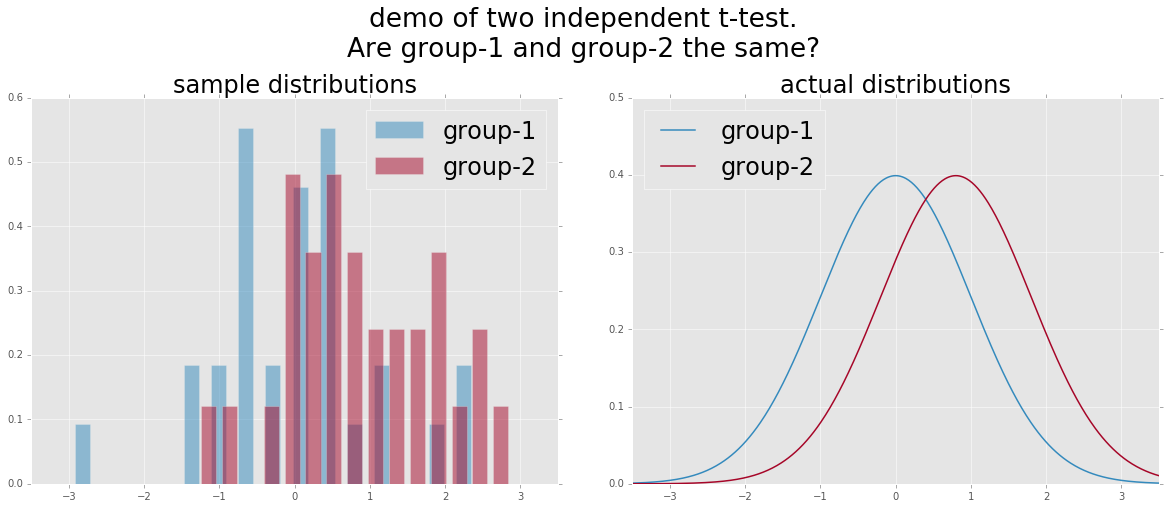

In [9]:
FONTSIZE = 24
plt.close('all')
fig = plt.figure(figsize=(16, 7))
gs = matplotlib.gridspec.GridSpec(1, 2)

ax = plt.subplot(gs[0, 0])
ax.bar(bar_locations1, hist1, width=0.2, alpha=0.5, label="group-1", color="#348ABD")
ax.bar(bar_locations2, hist2, width=0.2, alpha=0.5, label="group-2", color="#A60628")
ax.set_xlim(-3.5, 3.5)
ax.legend(loc="best", fontsize=FONTSIZE)
ax.set_title("sample distributions", fontsize=FONTSIZE)

ax = plt.subplot(gs[0, 1])
ax.plot(x_values, distributions[0,:], lw=1.5, label="group-1", color="#348ABD")
ax.plot(x_values, distributions[1,:], lw=1.5, label="group-2", color="#A60628")
ax.set_xlim(-3.5, 3.5)
ax.set_ylim(0, 0.5)
ax.legend(loc="best", fontsize=FONTSIZE)
ax.set_title("actual distributions", fontsize=FONTSIZE)


plt.tight_layout(pad=0, w_pad=5.0, h_pad=0)
fig.suptitle('demo of two independent t-test.\nAre group-1 and group-2 the same?', fontsize=1.1*FONTSIZE)
plt.subplots_adjust(top=0.8)


We use t-statistics to compare the means of two samples.

Below shows that the formula and the scipy.stats.ttest_ind can produce exactly the same result, good to know!

In [10]:
def calculateTstatistics(samples1, samples2):
    m1 = np.mean(samples1)
    s1 = np.std(samples1, ddof=1)
    m2 = np.mean(samples2)
    s2 = np.std(samples2, ddof=1)
    df1 = len(samples1) - 1
    df2 = len(samples2) - 1
    df = df1 + df2
    s_pooled = np.sqrt((df1*s1**2 + df2*s2**2)/float(df))
    t_statistics = (m2 - m1)/(s_pooled*np.sqrt(1.0/float(df1+1) + 1.0/float(df2+1)))
    p_value = (1.0 - scipy.stats.t(df=df).cdf(t_statistics))*2
    return (t_statistics, p_value)


In [17]:
# the t_statistics is the "effect size"
ind_test = calculateTstatistics(samples[0,:], samples[1,:])
print(ind_test)
print("")
print(scipy.stats.ttest_ind(samples[0,:], samples[1,:]))

print("")
if ind_test[1] < 0.05:
    print("Reject null hypothesis!")
else:
    print("Unable to reject null")


(3.1187239543846403, 0.0028271835517201804)

Ttest_indResult(statistic=-3.1187239543846403, pvalue=0.0028271835517201692)

Reject null hypothesis!


To calculate statistical power, we repeat the above simulation several times. For each simulation, we draw samples from group-1 and group-2, respectively, and perform the t-test. 
After all these simulations are done, we then check ow often do we reject null hupothesis (p_value < 0.05). 

In [18]:
n_simulations = 1000
data = np.zeros((n_simulations, n_per_group, n_groups))
for i_group in range(n_groups):
    normal_generator = scipy.stats.norm(loc=group_means[i_group],scale=group_stds[i_group])
    data[:, :, i_group] = normal_generator.rvs(size=(n_simulations, n_per_group))
    
result = scipy.stats.ttest_ind(data[:, :, 0], data[:, :, 1], axis=1)
power = np.mean(result[1] < 0.05)  # How often do we reject the null hypothesis
print('Power: {0:.3f}'.format(power))

Power: 0.850


Now, we would like to know the relation between the statistical power and the sample size. 

So we will try several sample sizes. 

For each sample size, we repeat the above procedure to calculate the statistical power. 

In the end, we can calculate the statistical power as a function of the sample size.

In [19]:
def calculatePower(group_means, group_stds, n_per_group):
    n_groups = len(group_means)
    n_simulations = 10000
    data = np.zeros((n_simulations, n_per_group, n_per_group))
    for i_group in range(n_groups):
        normal_generator = scipy.stats.norm(loc=group_means[i_group],scale=group_stds[i_group])
        data[:, :, i_group] = normal_generator.rvs(size=(n_simulations, n_per_group))
 
    result = scipy.stats.ttest_ind(data[:, :, 0], data[:, :, 1], axis=1)
    power = np.mean(result[1] < 0.05)  # How often do we reject the null hypothesis
    return power  

In [26]:
n_per_group = 5
desired_power = 0.9
current_power = 0.0
list_of_n_per_group = []
list_of_power = []
n_iters = 0
while current_power < desired_power and n_iters < 100:
    current_power = calculatePower(group_means, group_stds, n_per_group)
    list_of_n_per_group.append(n_per_group)
    list_of_power.append(current_power)
    n_per_group += 1
    n_iters += 1
    

In [24]:
def adjustAxeProperties(ax_obj, x_fontsize, x_rotation, y_fontsize, y_rotation):
    for tick in ax_obj.xaxis.get_major_ticks():
        tick.label.set_fontsize(x_fontsize)
        tick.label.set_rotation(x_rotation)
    for tick in ax_obj.yaxis.get_major_ticks():
        tick.label.set_fontsize(y_fontsize)
        tick.label.set_rotation(y_rotation)
        

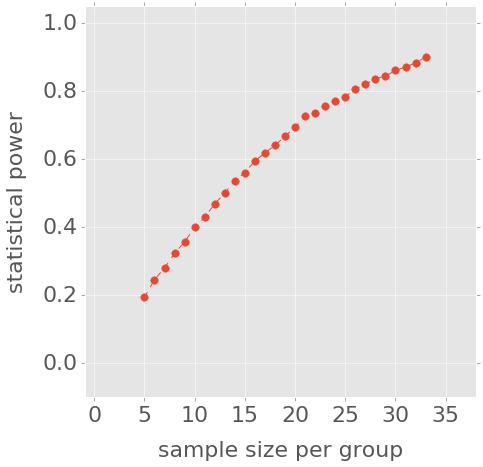

In [29]:
FONTSIZE = 22
plt.close('all')
fig, ax = plt.subplots(1, figsize=(7, 7))
ax.plot(list_of_n_per_group, list_of_power, marker='.', markersize=15, linestyle='--', linewidth=1)
ax.set_xlim(-0.9, list_of_n_per_group[-1]+5)
ax.set_ylim(-0.1, 1.05)
ax.set_xlabel("sample size per group", fontsize=FONTSIZE, labelpad=15)
ax.set_ylabel("statistical power", fontsize=FONTSIZE, labelpad=15)
adjustAxeProperties(ax, FONTSIZE, 0, FONTSIZE, 0)
